In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#Required Libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout,BatchNormalization,GlobalAveragePooling2D, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import CosineDecay


In [ ]:
import os
import cv2
import numpy as np
from zipfile import ZipFile
from tqdm import tqdm

#Unzip DDSM Dataset
zip_path = '/content/drive/MyDrive/DDSM Datasetzipped.zip'
extract_path = '/content/DDSM Dataset'

if not os.path.exists(extract_path):
    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print("Unzipped dataset to:", extract_path)
else:
    print("Dataset already unzipped.")

#Preprocessing function
def preprocess_and_save(src_dir, dest_dir, img_size=(224, 224)):
    os.makedirs(dest_dir, exist_ok=True)
    files = [f for f in os.listdir(src_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

    for f in tqdm(files, desc=f"Processing {os.path.basename(src_dir)}"):
        img_path = os.path.join(src_dir, f)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Could not read {img_path}")
            continue

        # Resize
        img_resized = cv2.resize(img, img_size)
        # Apply CLAHE
        img_clahe = clahe.apply(img_resized)


        save_path = os.path.join(dest_dir, os.path.splitext(f)[0] + '.png')
        cv2.imwrite(save_path, img_clahe)

source_root = '/content/DDSM Dataset'
processed_root = '/content/Processed_DDSM'

for cls in ['Benign', 'Malignant']:
    src_class_dir = os.path.join(source_root, cls + ' Masses')
    dest_class_dir = os.path.join(processed_root, cls.lower())
    preprocess_and_save(src_class_dir, dest_class_dir)

print("Preprocessing complete.")


Dataset already unzipped.


Processing Malignant Masses: 100%|██████████| 7158/7158 [00:18<00:00, 385.25it/s]

Preprocessing complete.


In [ ]:
import os
print(os.listdir('/content/DDSM Dataset'))


['Benign Masses', 'Malignant Masses']


In [ ]:
import os
import shutil
import random

def split_and_copy(src_dir, dest_root, class_name, train_ratio=0.7, val_ratio=0.15, seed=42):
    random.seed(seed)
    files = [f for f in os.listdir(src_dir) if f.lower().endswith('.png')]
    random.shuffle(files)

    total = len(files)
    train_cutoff = int(total * train_ratio)
    val_cutoff = int(total * (train_ratio + val_ratio))

    splits = {
        'train': files[:train_cutoff],
        'val': files[train_cutoff:val_cutoff],
        'test': files[val_cutoff:]
    }

    for split_name, split_files in splits.items():
        split_dir = os.path.join(dest_root, split_name, class_name)
        os.makedirs(split_dir, exist_ok=True)
        for fname in split_files:
            shutil.copy2(os.path.join(src_dir, fname), os.path.join(split_dir, fname))


processed_root = '/content/Processed_DDSM'
final_data_root = '/content/DDSM_split'

for cls in ['benign', 'malignant']:
    src_folder = os.path.join(processed_root, cls)
    split_and_copy(src_folder, final_data_root, cls)

print("Data splitting complete.")


Data splitting complete.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height, img_width = 224, 224
batch_size = 16

train_dir = '/content/DDSM_split/train'
val_dir = '/content/DDSM_split/val'
test_dir = '/content/DDSM_split/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 9189 images belonging to 2 classes.
Found 1969 images belonging to 2 classes.
Found 1970 images belonging to 2 classes.


In [ ]:
import os

def count_images_in_folder(folder_path):
    class_counts = {}
    for class_name in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, class_name)
        if os.path.isdir(class_dir):
            image_files = [
                f for f in os.listdir(class_dir)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ]
            class_counts[class_name] = len(image_files)
    return class_counts

# Check all splits
train_counts = count_images_in_folder('/content/DDSM_split/train')
val_counts = count_images_in_folder('/content/DDSM_split/val')
test_counts = count_images_in_folder('/content/DDSM_split/test')

print(" Training set class counts:", train_counts)
print(" Validation set class counts:", val_counts)
print(" Test set class counts:", test_counts)


📂 Training set class counts: {'benign': 4179, 'malignant': 5010}
📊 Validation set class counts: {'benign': 895, 'malignant': 1074}
🧪 Test set class counts: {'benign': 896, 'malignant': 1074}


In [ ]:
from tensorflow.keras import regularizers

# Initializing model
model = Sequential()

model.add(Input(shape=(224, 224, 1)))

# Conv Block 1
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))


In [ ]:
# Conv Block 2
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.00005)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.00005)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

In [ ]:
# Conv Block 3
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.00005)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.00005)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

In [ ]:
# Block 4
'''
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
'''

"\nmodel.add(Conv2D(256, (3, 3), activation='relu', padding='same'))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\n"

In [ ]:
# Flatten + Dense Layers
model.add(GlobalAveragePooling2D())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1))
model.add(Activation('sigmoid'))


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_names = ['benign', 'malignant']
class_indices = {name: i for i, name in enumerate(class_names)}

train_labels = ['malignant'] * 5010 + ['benign'] * 4179

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.array(class_names),
    y=train_labels
)
class_weights = {
    class_indices[class_name]: weight
    for class_name, weight in zip(class_names, class_weights_array)
}

print("⚖️ Computed class weights:", class_weights)


⚖️ Computed class weights: {0: np.float64(1.0994256999282126), 1: np.float64(0.917065868263473)}


In [ ]:

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=5e-5),
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/breast_cancer_model_epoch_{epoch:02d}.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             

 Total params: 912,293 (3.48 MB)

 Trainable params: 303,841 (1.16 MB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 607,684 (2.32 MB)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    class_weight=class_weights,
    callbacks=early_stop,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


575/575 ━━━━━━━━━━━━━━━━━━━━ 76s 115ms/step - accuracy: 0.5011 - loss: 0.7778 - val_accuracy: 0.5455 - val_loss: 0.7036
Epoch 2/30
575/575 ━━━━━━━━━━━━━━━━━━━━ 70s 105ms/step - accuracy: 0.5259 - loss: 0.7170 - val_accuracy: 0.5571 - val_loss: 0.6850
Epoch 3/30
575/575 ━━━━━━━━━━━━━━━━━━━━ 80s 102ms/step - accuracy: 0.5805 - loss: 0.6867 - val_accuracy: 0.7852 - val_loss: 0.5899
Epoch 4/30
575/575 ━━━━━━━━━━━━━━━━━━━━ 82s 102ms/step - accuracy: 0.7174 - loss: 0.5944 - val_accuracy: 0.8959 - val_loss: 0.3917
Epoch 5/30
575/575 ━━━━━━━━━━━━━━━━━━━━ 61s 106ms/step - accuracy: 0.8015 - loss: 0.4974 - val_accuracy: 0.9223 - val_loss: 0.3074
Epoch 6/30
575/575 ━━━━━━━━━━━━━━━━━━━━ 59s 102ms/step - accuracy: 0.8323 - loss: 0.4287 - val_accuracy: 0.9081 - val_loss: 0.2864
Epoch 7/30
575/575 ━━━━━━━━━━━━━━━━━━━━ 62s 108ms/step - accuracy: 0.8456 - loss: 0.4109 - val_accuracy: 0.8634 - val_loss: 0.3271
Epoch 8/30
575/575 ━━━━━━━━━━━━━━━━━━━━ 79s 103ms/step - accuracy: 0.8679 - loss: 0.3583 - val

In [ ]:
model.save('/content/drive/MyDrive/models/ddsm_final_model.h5')


In [ ]:
# Evaluate
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9624 - loss: 0.1633
✅ Test Accuracy: 0.9635
📉 Test Loss: 0.1581


In [ ]:
y_true = test_generator.classes
y_probs = model.predict(test_generator, verbose=1)
y_preds = (y_probs > 0.5).astype(int).flatten()

124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step


In [ ]:
from sklearn.metrics import classification_report

#classification report
print(classification_report(
    y_true,
    y_preds,
    target_names=['Benign', 'Malignant'],
    digits=4
))


              precision    recall  f1-score   support

      Benign     0.9547    0.9654    0.9600       896
   Malignant     0.9709    0.9618    0.9663      1074

    accuracy                         0.9635      1970
   macro avg     0.9628    0.9636    0.9632      1970
weighted avg     0.9635    0.9635    0.9635      1970



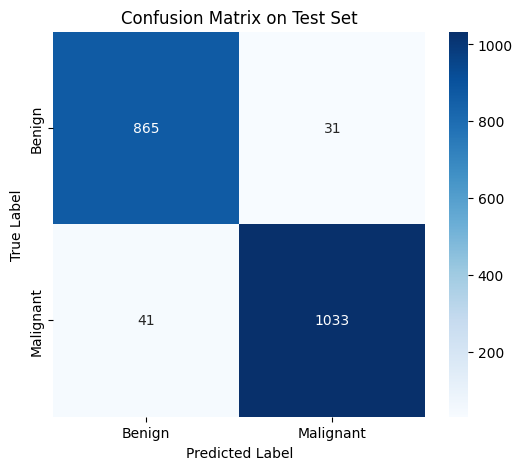

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#confusion matrix
cm = confusion_matrix(y_true, y_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.show()


In [ ]:
import numpy as np

# Ground truth labels
y_true = test_generator.classes

# Predicted probabilities
y_probs = model.predict(test_generator, verbose=1)

# Convert probabilities to binary predictions
y_preds = (y_probs > 0.5).astype(int).flatten()


124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step


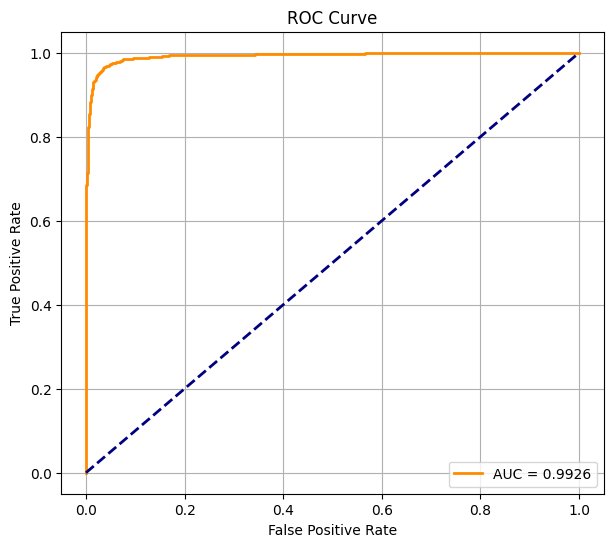

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


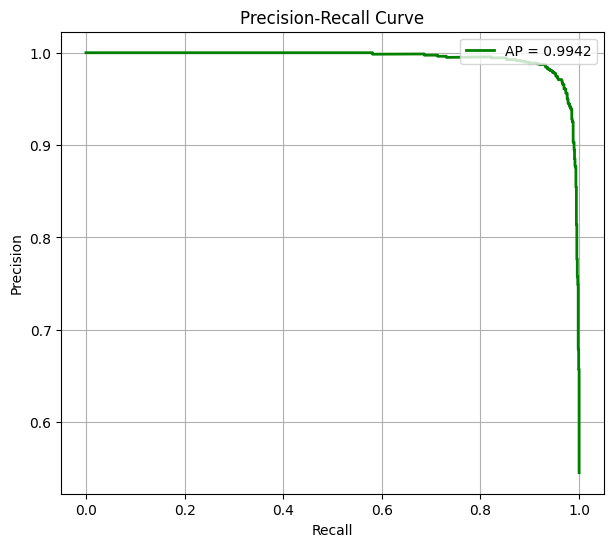

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_true, y_probs)
ap_score = average_precision_score(y_true, y_probs)

plt.figure(figsize=(7,6))
plt.plot(recall, precision, color='green', lw=2, label=f'AP = {ap_score:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [ ]:
!pip install imagehash


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 7.1 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import imagehash
from PIL import Image
from collections import defaultdict

# Set paths
base_dir = '/content/DDSM_split'
splits = ['train', 'val', 'test']

# Dictionary to store hash -> list of (split, path)
hash_dict = defaultdict(list)

# Loop over all splits and compute image hashes
for split in splits:
    for cls in ['benign', 'malignant']:
        folder = os.path.join(base_dir, split, cls)
        for fname in os.listdir(folder):
            if fname.lower().endswith('.png'):
                fpath = os.path.join(folder, fname)
                try:
                    img = Image.open(fpath).convert("L").resize((224, 224))
                    hash_val = str(imagehash.phash(img))
                    hash_dict[hash_val].append((split, fpath))
                except Exception as e:
                    print(f"Error reading {fpath}: {e}")

# Check for duplicates across splits
duplicate_groups = [v for v in hash_dict.values() if len(v) > 1]
print(f"🔍 Found {len(duplicate_groups)} duplicate image groups across splits.\n")

for group in duplicate_groups[:10]:  # show first 10 groups
    print("🟡 Duplicate group:")
    for split, path in group:
        print(f"   [{split}] {path}")
    print()


🔍 Found 0 duplicate image groups across splits.



In [ ]:
model.save('/content/drive/MyDrive/final_breast_cancer_model.keras')


In [ ]:
#Model loading
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/final_breast_cancer_model.keras')
